In [1]:
# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(PROJ_DIR,'src'))
import xai_faithfulness_experiments_lib_edits as fl
import numpy as np
import captum_generator as cg
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

METHOD_NAMES = ['Saliency', 'IntegratedGradients', 'InputXGradient', 'GuidedBackprop', 'Deconvolution', 'LayerGradCam', 'GuidedGradCam']

ACTIVATION_THRESHOLD = 0.9
Z_SCORE_THRESHOLD = 4
DESIRED_EXPLANATIONS = 1000

DATASET = 'imagenet'
MODEL_NAME = 'resnet18-logits'

# Load dataset
if DATASET == '20newsgroups-truncated':
    DATASET_PATH = os.path.join(PROJ_DIR,'assets', 'data', f'{DATASET}.npz')
    # Load dataset
    file_data = np.load(DATASET_PATH)
    x_train = torch.from_numpy(file_data['x_train']).float().to(device)
    y_train = torch.from_numpy(file_data['y_train']).to(device)
    test_loader = [(x_train, y_train)]
else:
    #torch.manual_seed(0)
    test_loader = fl.get_image_test_loader(DATASET, 1000, PROJ_DIR, shuffle = True)


# Load model
if DATASET == 'imagenet':
    network = fl.load_pretrained_imagenet_model(arch = MODEL_NAME.replace('-logits', ''), use_logits = '-logits' in MODEL_NAME)
    DATA_MEAN = [0.485, 0.456, 0.406]
    DATA_STD = [0.229, 0.224, 0.225]
elif DATASET == 'mnist':
    MODEL_PATH = os.path.join(PROJ_DIR,'assets', 'models', f'{DATASET}-{MODEL_NAME}-mlp.pth')
    network = fl.load_pretrained_mnist_model(MODEL_PATH)
    DATA_MEAN = [0.1307]
    DATA_STD = [0.3081]
elif DATASET == 'cifar':
    MODEL_PATH = os.path.join(PROJ_DIR,'assets', 'models', f'{DATASET}-{MODEL_NAME}-mlp.pth')
    network = fl.load_pretrained_cifar_model(MODEL_PATH)
elif DATASET == '20newsgroups-truncated':
    MODEL_PATH = os.path.join(PROJ_DIR,'assets', 'models', f'{DATASET}{MODEL_NAME}-mlp.pth')
    network = fl.load_pretrained_mlp_large_model(MODEL_PATH, x_train.shape[1], 20, [1000, 1000, 800, 500])
    DATA_MEAN = [0.2675, 0.2565, 0.2761]
    DATA_STD = [0.5071, 0.4867, 0.4408]
else:
    raise Exception(f'ERROR: Unknown dataset {DATASET}')

Using cuda:0
Loading Resnet18


In [2]:
import pickle

FILENAME = f'{DATASET}_{MODEL_NAME}_noise_exceptionals.pkl'

if os.path.isfile(os.path.join(PROJ_DIR, 'results', FILENAME)):
    with open(os.path.join(PROJ_DIR, 'results', FILENAME), 'rb') as fIn:
        results = pickle.load(fIn)
else:
    # The mean is zero because this dataset is standardized
    num_vars = None
    masking_values = None

    with torch.no_grad():
        valid_elements = []

        for batch_idx, (x_train, y_train) in enumerate(test_loader):
            print(f'Loaded batch  {batch_idx}')
            if masking_values is None:
                masking_values = torch.from_numpy(np.zeros(x_train.shape[1:])).float().to(device)
                num_vars  = 1
                for d in x_train.shape[1:]:
                    num_vars *= d
                num_samples = min(fl.NUM_SAMPLES, num_vars)
                input_shape = x_train.shape[1:]
            # Find elements from the batch that activate the network enough
            outputs = network(x_train.to(device))
            activated_indices = (outputs[torch.arange(x_train.shape[0]), y_train]>ACTIVATION_THRESHOLD).nonzero().flatten()

            for i, sample_index in enumerate(activated_indices):
                if (i+1) % 10 == 0:
                    print(f' Exploring activating sample {i+1}/{activated_indices.size()[0]}')
                row = x_train[sample_index.item()].to(device)
                label = y_train[sample_index.item()].to(device)
            
                #Compute 100 random rankings to compute the average q
                qmeans = []
                for _ in range(100):
                    measures = fl.get_measures_for_ranking(row, fl._get_random_ranking_row(row.shape), label, network, with_inverse=False, with_random=False, masking_values=masking_values)
                    qmeans.append(measures['mean'])
                qmean_mean = np.mean(qmeans)
                qmean_std = np.std(qmeans)
        
                #Grab captum generated explanations and check their z-index
                captum_rankings = torch.tensor(cg.generate_rankings(row, label, network)).to(device)
                for method_index, ranking in enumerate(captum_rankings):
                    measures = fl.get_measures_for_ranking(row, ranking, label, network, with_inverse=False, with_random=False, masking_values=masking_values)
                    zscore = (measures['mean'] -  qmean_mean) /  qmean_std
                    if zscore > 4:
                        valid_elements.append({'row': row,\
                                            'ranking': ranking,\
                                            'label': label,\
                                            'qmean_mean': qmean_mean,\
                                            'qmean_std': qmean_std,\
                                            'method': method_index
                                            })
                        print(f'{len(valid_elements)}/{DESIRED_EXPLANATIONS}')
                        if len(valid_elements) >= DESIRED_EXPLANATIONS:
                            break
                if len(valid_elements) >= DESIRED_EXPLANATIONS:
                    break

    results = []
    for v in valid_elements:
        row  = v['row']
        ranking = v['ranking']
        label = v['label']
        measures = fl.get_measures_for_ranking(row, ranking, label, network, with_inverse=True, with_random=True, masking_values=masking_values)
        v['qmean'] = measures['mean']
        v['qinv'] = measures['mean_inv']
        v['qbas'] = measures['mean_bas']
        results.append(v)
    with open(os.path.join(PROJ_DIR, 'results', FILENAME), 'wb') as fOut:
        pickle.dump(results, fOut)
                

Loaded batch  0


/home/eirasf/miniconda3/envs/xai-anna/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/eirasf/miniconda3/envs/xai-anna/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


1/1000
2/1000
3/1000
4/1000


KeyboardInterrupt: 

0.5489219676084859


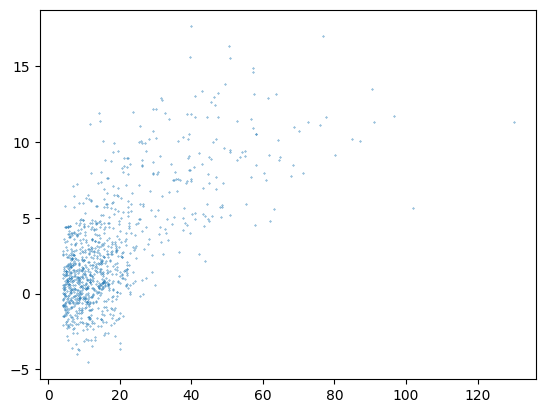

0.8785466609190559


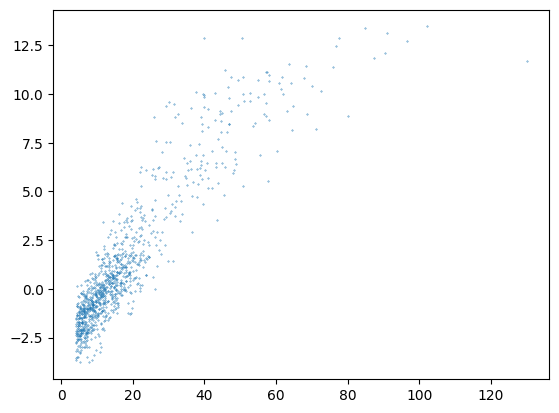

In [5]:
#filtered = [x for x in results if x['qmean']>0.5]
filtered = results
#filtered = [x for x in results if x['method']==5]

from scipy.stats import spearmanr
from matplotlib import pyplot as plt
zindices = list(map(lambda x: (x['qmean']-x['qmean_mean'])/x['qmean_std'], filtered))
#zindices = list(map(lambda x: x['qmean'], filtered))
qinv = list(map(lambda x: x['qinv'], filtered))
qbas = list(map(lambda x: x['qbas'], filtered))

print(spearmanr(zindices, qinv).statistic)
plt.scatter(zindices,  qinv, s=0.1)
plt.show()
print(spearmanr(zindices, qbas).statistic)
plt.scatter(zindices,  qbas, s=0.1)
plt.show()

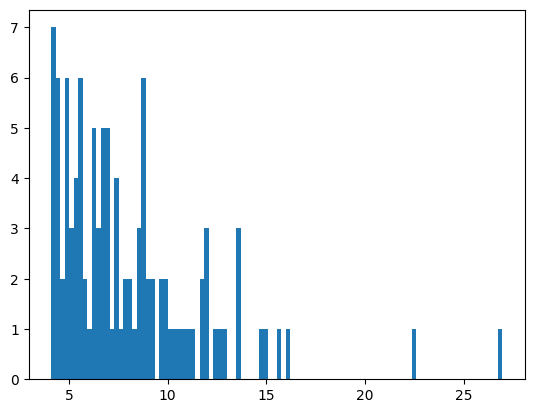

In [11]:
plt.hist(zindices, bins=100)
plt.show()

In [7]:
NUM_ELEMS = 5
NUM_CURVES = 10

#indices = torch.tensor(qinv).topk(NUM_ELEMS, largest=True).indices
indices = torch.tensor(zindices).topk(NUM_ELEMS, largest=True).indices

data_std_tensor = torch.tensor(np.reshape(DATA_STD, (3,1,1))).to(device)
data_mean_tensor = torch.tensor(np.reshape(DATA_MEAN, (3,1,1))).to(device)

for i in indices:
    v = filtered[i]
    print(METHOD_NAMES[v['method']])
    print(v.keys())
    row  = v['row']
    ranking = v['ranking']
    inverse_ranking = v['inverse_ranking']
    label = v['label']
    masking_values = torch.from_numpy(np.zeros(row.shape)).float().to(device)
    measures = fl.get_measures_for_ranking(row, ranking, label, network, with_inverse=True, with_random=True, masking_values=masking_values)
    measures_inverse = fl.get_measures_for_ranking(row, inverse_ranking, label, network, with_inverse=False, with_random=False, masking_values=masking_values)
    
    masking_values_red = torch.clone(masking_values)
    masking_values_red[1,:,:] = 1
    printable_image_tensor = row * data_std_tensor + data_mean_tensor

    print('Mean', measures['mean'])
    print('qmean', v['qmean_mean'])
    print('qstd',v['qmean_std'])
    print(network(row.unsqueeze(0)).max())
    fig, axs = plt.subplots(1, 3, figsize=(10, 2))
    axs[0].plot(measures['output_curve'], color='green')
    axs[0].plot(measures['output_curve_inv'], color='orange')
    axs[0].plot(measures_inverse['output_curve'], color='red')
    axs[0].plot(measures['output_curve_bas'], color='gray', linewidth=0.2)
    for _ in range(NUM_CURVES):
        measures_random = fl.get_measures_for_ranking(row, fl._get_random_ranking_row(ranking.shape), label, network, with_inverse=False, with_random=False, masking_values=masking_values)
        axs[0].plot(measures_random['output_curve'], color='gray', linewidth=0.2)
    axs[1].imshow(np.moveaxis(printable_image_tensor.detach().cpu().numpy(), 0, -1))
    axs[2].imshow(v['ranking'].sum(axis=0).detach().cpu().numpy(), cmap='plasma')
    plt.show()

    masked = fl._get_masked_inputs(row, masking_values, ranking, torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))
    masked_printable = fl._get_masked_inputs(printable_image_tensor, masking_values_red, ranking, torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 2))
    for pos, (m, r) in enumerate(zip(masked, masked_printable)):
        axs[pos].imshow(np.moveaxis(r.detach().cpu().numpy(), 0, -1))
        axs[pos].set_yticks([])
        axs[pos].set_xticks([])
        axs[pos].set_title(f'{network(m.unsqueeze(0)).squeeze()[label].item():.4f}')
    plt.suptitle('Ranking')
    plt.show()
    masked_inverse = fl._get_masked_inputs(row, masking_values, torch.tensor(fl._attributions_to_ranking_row(ranking.flatten().detach().cpu(), reverse=True).reshape(ranking.shape)).to(device), torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))
    masked_inverse_printable = fl._get_masked_inputs(printable_image_tensor, masking_values_red, torch.tensor(fl._attributions_to_ranking_row(ranking.flatten().detach().cpu(), reverse=True).reshape(ranking.shape)).to(device), torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))
    fig, axs = plt.subplots(1, 4, figsize=(10, 2))
    for pos, (m,r) in enumerate(zip(masked_inverse, masked_inverse_printable)):
        axs[pos].imshow(np.moveaxis(r.detach().cpu().numpy(), 0, -1))
        axs[pos].set_yticks([])
        axs[pos].set_xticks([])
        axs[pos].set_title(f'{network(m.unsqueeze(0)).squeeze()[label].item():.4f}')
    plt.suptitle('Inverse')
    plt.show()
    random_row = fl._get_random_ranking_row(ranking.shape)
    masked_random = fl._get_masked_inputs(row, masking_values, random_row, torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))
    masked_random_printable = fl._get_masked_inputs(printable_image_tensor, masking_values_red, random_row, torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))
    fig, axs = plt.subplots(1, 4, figsize=(10, 2))
    for pos, (m,r) in enumerate(zip(masked_random,masked_random_printable)):
        axs[pos].imshow(np.moveaxis(r.detach().cpu().numpy(), 0, -1))
        axs[pos].set_yticks([])
        axs[pos].set_xticks([])
        axs[pos].set_title(f'{network(m.unsqueeze(0)).squeeze()[label].item():.4f}')
    plt.suptitle('Random')
    plt.show()

LayerGradCam
dict_keys(['row', 'ranking', 'label', 'qmean_mean', 'qmean_std', 'method', 'qmean', 'qinv', 'qbas'])


KeyError: 'inverse_ranking'

In [5]:
from captum.attr import GuidedGradCam,LayerGradCam,LayerAttribution
explanation = GuidedGradCam(network, network.network.features[28]).attribute(inputs=row.unsqueeze(0), target=label.unsqueeze(0))
print(explanation.shape)
explanation=LayerAttribution.interpolate(explanation, row.shape[1:])
#explanation = torch.stack([explanation, explanation, explanation], dim=1).squeeze()
explanation = explanation.squeeze()
print(printable_image_tensor.shape)
print(explanation.shape)
plt.imshow(np.moveaxis(printable_image_tensor.detach().cpu().numpy(),0,-1))
plt.show()
printable_explanation = (explanation - explanation.min())/(explanation.max()-explanation.min())
plt.imshow(np.moveaxis(printable_explanation.detach().cpu().numpy(),0,-1))
plt.show()


ranking = torch.tensor(fl._attributions_to_ranking_row(explanation.flatten().detach().cpu(), reverse=False).reshape(ranking.shape)).to(device)
plt.imshow(np.moveaxis(ranking.detach().cpu().numpy(),0,-1))
plt.show()
masked = fl._get_masked_inputs(row, masking_values, ranking, torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))
masked_printable = fl._get_masked_inputs(printable_image_tensor, masking_values_red, ranking, torch.tensor([0.2, 0.4, 0.6, 0.8]).to(device))

fig, axs = plt.subplots(1, 4, figsize=(10, 2))
for pos, (m, r) in enumerate(zip(masked, masked_printable)):
    axs[pos].imshow(np.moveaxis(r.detach().cpu().numpy(), 0, -1))
    axs[pos].set_yticks([])
    axs[pos].set_xticks([])
    axs[pos].set_title(f'{network(m.unsqueeze(0)).squeeze()[label].item():.4f}')
plt.suptitle('Ranking')
plt.show()

AttributeError: 'ResNet' object has no attribute 'features'

In [87]:
max([i for i in range(len(network.network.features)) if type(network.network.features[i]) == torch.nn.modules.conv.Conv2d])

28

In [11]:
for m in network.modules():
    print(type(m))

<class 'xai_faithfulness_experiments_lib_edits.LogitToOHEWrapper'>
<class 'torchvision.models.resnet.ResNet'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torchvision.models.resnet.BasicBlock'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torchvision.models.resnet.BasicBlock'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torchvision.models.resnet.BasicBlock'>
<class 'torch.nn.modules.conv.Conv2d'>
